In [1]:
import tensorflow as tf
import numpy as np
import glob 
import os
import matplotlib.pyplot as plt
import matplotlib
import scipy

In [2]:
gpus = tf.config.experimental.list_physical_devices( device_type = 'GPU' )
# 设置该程序可见的GPU：写到最前面！
tf.config.experimental.set_visible_devices( devices = gpus[3:5], device_type = 'GPU' )

### 1. 导入所有文件的路径：

In [3]:
# 所有训练图片的地址：
image_path = glob.glob( '/home/gaoboyu/学习数据集/沙漠数据集8_250/图像/*' )
label_path = glob.glob( '/home/gaoboyu/学习数据集/沙漠数据集8_250/处理后标签/*' )
# 排序：
image_path.sort( key = lambda x:int(x.split('/')[-1].split('.')[0].split('_')[-1]) )
label_path.sort( key = lambda x:int(x.split('/')[-1].split('.')[0].split('_')[-1]) )

In [4]:
image_count = len(image_path)
len(image_path), len(label_path)

(250, 250)

In [5]:
# 查看是否对应：
image_path[21:23], label_path[21:23]  # 顺序不对应！

(['/home/gaoboyu/学习数据集/沙漠数据集8_250/图像/subimg_21.png',
  '/home/gaoboyu/学习数据集/沙漠数据集8_250/图像/subimg_22.png'],
 ['/home/gaoboyu/学习数据集/沙漠数据集8_250/处理后标签/subimg_21.png',
  '/home/gaoboyu/学习数据集/沙漠数据集8_250/处理后标签/subimg_22.png'])

In [6]:
# 最后数据的乱序：
index = np.random.permutation( image_count )
image_path = np.array(image_path)[index]
label_path = np.array(label_path)[index]

In [7]:
# 再测试：
image_path[21:23], label_path[21:23]  # 顺序不对应！

(array(['/home/gaoboyu/学习数据集/沙漠数据集8_250/图像/subimg_908.png',
        '/home/gaoboyu/学习数据集/沙漠数据集8_250/图像/subimg_72.png'], dtype='<U49'),
 array(['/home/gaoboyu/学习数据集/沙漠数据集8_250/处理后标签/subimg_908.png',
        '/home/gaoboyu/学习数据集/沙漠数据集8_250/处理后标签/subimg_72.png'], dtype='<U52'))

### 2. 创建数据集：

In [8]:
dataset = tf.data.Dataset.from_tensor_slices( (image_path, label_path) )

In [9]:
# 划分训练、测试集
val_count = int( image_count*0.2 )
train_count = image_count - val_count

train_dataset = dataset.skip(val_count)  # 跳过前这么多数据
val_dataset = dataset.take(val_count)   # 取前面这么多数据

In [10]:
val_count, train_count

(50, 200)

In [11]:
# 查看：
train_dataset, val_dataset

(<SkipDataset shapes: ((), ()), types: (tf.string, tf.string)>,
 <TakeDataset shapes: ((), ()), types: (tf.string, tf.string)>)

### 3. 预处理函数：

In [12]:
# 读取图片：3通道
def read_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels = 3)
    return img

In [13]:
# 读取标签：1通道（每个像素都是标签值）
def read_label(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels = 1)
    return img

In [14]:
# 对训练数据及标签：随机翻转 —— 训练数据专用！
def random_flip(img, label):
    img_label = tf.concat( [img, label], axis = -1 )  # 图像与标签合并
    img_label = tf.image.resize(img_label, [256,256])
    img_label = tf.image.random_flip_left_right(img_label)  # 随机左右翻转
    img_label = tf.image.random_flip_up_down(img_label)     # 随机上下翻转
    return img_label[:,:,0:3], img_label[:,:,3:]

In [15]:
# 所有图像归一化 + 标签转数据类型：
def normal(img, label):
    img = tf.cast(img, tf.float32) / 127.5 - 1
    label = tf.cast(label, tf.int32)  # 不能减1，因为里面本身就有0的标签！ 
    return img, label

In [16]:
# 训练数据加载：需要裁减！
def load_train_image(img_path, label_path):
    # 获取图片与标签：
    img = read_image(img_path)
    label = read_label(label_path)
    # 预处理：随机翻转 —— 自带统一形状！
    img, label = random_flip(img, label)
    # 返回归一化：
    return normal(img, label)

def load_val_image(img_path, label_path):
    # 获取图片与标签：
    img = read_image(img_path)
    label = read_label(label_path)
    # 统一形状：
    img = tf.image.resize(img, [256,256])
    label = tf.image.resize(label, [256,256])
    # 返回归一化：
    return normal(img, label)

In [17]:
# 将数据应用于函数：
AUTOTUNE = tf.data.experimental.AUTOTUNE   # 多线程加载：图像加载是cpu处理的，cpu可以做多线程！

train_dataset = train_dataset.map( load_train_image, num_parallel_calls = AUTOTUNE )
val_dataset = val_dataset.map( load_val_image, num_parallel_calls = AUTOTUNE )

In [18]:
train_dataset, val_dataset

(<ParallelMapDataset shapes: ((256, 256, 3), (256, 256, 1)), types: (tf.float32, tf.int32)>,
 <ParallelMapDataset shapes: ((256, 256, 3), (256, 256, 1)), types: (tf.float32, tf.int32)>)

In [19]:
# 乱序、划分数据集：
# cashe()：新操作，文件不断放到缓存中，加速！
# prefetch()：新操作，GPU内存不等待，不断预处理图片
BATCH_SIZE = 10
train_dataset = train_dataset.cache().shuffle(train_count).repeat().batch(BATCH_SIZE).prefetch(AUTOTUNE)
val_dataset = val_dataset.cache().batch(BATCH_SIZE)

In [20]:
train_dataset, val_dataset

(<PrefetchDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.int32)>,
 <BatchDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.int32)>)

### 4. 模型搭建：半网Dropout + BatchNormalization

说明，下面进行各种 “半网加Dropout层” 的尝试：
- 前半办法加，后半部分不加；

In [21]:
model = tf.keras.models.load_model( 'model5_150_调过拟合_半网.h5' )  # 90%

In [22]:
# 模型编译
model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['acc']
)

In [23]:
# 定义保存模型的回调函数：保存整个模型、只保存最好的！
# 设置保存的路径：
checkpoint_path = '/home/gaoboyu/学习保存的模型/沙漠8_用5模型'
# 设置回调函数保存模型：没设置的参数都默认
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_path,
    monitor = 'val_acc',
    save_best_only = True  # 监控的目标：如果新的epoch结果比前一个要好，那就重新保存最新的，删掉旧的！
)

In [24]:
# 模型训练
EPOCHES = 50
history = model.fit(
    train_dataset,
    epochs = EPOCHES,
    steps_per_epoch = train_count // BATCH_SIZE,
    validation_data = val_dataset,
    validation_steps = val_count // BATCH_SIZE,
    # 回调函数：
    callbacks = [cp_callback]
)

Epoch 1/50
20/20 [==============================] - ETA: 0s - loss: 0.2534 - acc: 0.9143WARNING:tensorflow:From /usr/local/Anaconda33/lib/python3.7/site-packages/tensorflow/python/ops/resource_variable_ops.py:1817: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /home/gaoboyu/学习保存的模型/沙漠8_用5模型/assets
20/20 [==============================] - 40s 2s/step - loss: 0.2534 - acc: 0.9143 - val_loss: 0.4389 - val_acc: 0.8375
Epoch 2/50
20/20 [==============================] - 36s 2s/step - loss: 0.1748 - acc: 0.9277 - val_loss: 0.2855 - val_acc: 0.9139
Epoch 3/50
20/20 [==============================] - 36s 2s/step - loss: 0.1618 - acc: 0.9323 - val_loss: 0.2608 - val_acc: 0.9163
Epoch 4/50
20/20 [==============================] - 27s 1s/step - loss: 0.1518 - acc: 0.9359

In [25]:
# 降速训练1（0.0001）：再次编译 + 再次训练
model.compile(
    optimizer = tf.keras.optimizers.Adam( lr = 0.0001 / 5 ),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['acc']
)

# 再次训练：
initial_epochs = EPOCHES
final_epochs = 50  # 再多训练10个epoch
total_epochs = initial_epochs + final_epochs

history = model.fit(
    train_dataset,
    epochs = total_epochs,
    initial_epoch = initial_epochs,  # 数值从initial_epochs开始记录而已！
    steps_per_epoch = train_count // BATCH_SIZE,
    validation_data = val_dataset,
    validation_steps = val_count // BATCH_SIZE,
    # 回调函数：
    # callbacks = [cp_callback]
)

Epoch 51/100
20/20 [==============================] - 28s 1s/step - loss: 0.0370 - acc: 0.9845 - val_loss: 0.3863 - val_acc: 0.9174
Epoch 52/100
20/20 [==============================] - 27s 1s/step - loss: 0.0362 - acc: 0.9848 - val_loss: 0.3883 - val_acc: 0.9170
Epoch 53/100
20/20 [==============================] - 27s 1s/step - loss: 0.0360 - acc: 0.9849 - val_loss: 0.3868 - val_acc: 0.9170
Epoch 54/100
20/20 [==============================] - 27s 1s/step - loss: 0.0360 - acc: 0.9849 - val_loss: 0.3887 - val_acc: 0.9167
Epoch 55/100
20/20 [==============================] - 27s 1s/step - loss: 0.0360 - acc: 0.9849 - val_loss: 0.3913 - val_acc: 0.9165
Epoch 56/100
20/20 [==============================] - 27s 1s/step - loss: 0.0358 - acc: 0.9850 - val_loss: 0.3855 - val_acc: 0.9167
Epoch 57/100
20/20 [==============================] - 27s 1s/step - loss: 0.0357 - acc: 0.9851 - val_loss: 0.3896 - val_acc: 0.9163
Epoch 58/100
20/20 [==============================] - 27s 1s/step - loss: 0.

In [26]:
model.save( 'model8_250_用m5网络预训练.h5' )

In [27]:
# 降速训练1（0.0001）：再次编译 + 再次训练
model.compile(
    optimizer = tf.keras.optimizers.Adam( lr = 0.0001 / 5 ),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['acc']
)

# 再次训练：
initial_epochs = EPOCHES
final_epochs = 30  # 再多训练10个epoch
total_epochs = initial_epochs + final_epochs

history = model.fit(
    train_dataset,
    epochs = total_epochs,
    initial_epoch = initial_epochs,  # 数值从initial_epochs开始记录而已！
    steps_per_epoch = train_count // BATCH_SIZE,
    validation_data = val_dataset,
    validation_steps = val_count // BATCH_SIZE,
    # 回调函数：
    # callbacks = [cp_callback]
)

Epoch 201/230
15/15 [==============================] - 20s 1s/step - loss: 0.0247 - acc: 0.9898 - val_loss: 0.4161 - val_acc: 0.9220
Epoch 202/230
15/15 [==============================] - 20s 1s/step - loss: 0.0246 - acc: 0.9898 - val_loss: 0.4175 - val_acc: 0.9219
Epoch 203/230
15/15 [==============================] - 20s 1s/step - loss: 0.0243 - acc: 0.9900 - val_loss: 0.4221 - val_acc: 0.9215
Epoch 204/230
15/15 [==============================] - 20s 1s/step - loss: 0.0245 - acc: 0.9899 - val_loss: 0.4235 - val_acc: 0.9214
Epoch 205/230
15/15 [==============================] - 20s 1s/step - loss: 0.0246 - acc: 0.9899 - val_loss: 0.4143 - val_acc: 0.9222
Epoch 206/230
15/15 [==============================] - 20s 1s/step - loss: 0.0249 - acc: 0.9897 - val_loss: 0.4128 - val_acc: 0.9220
Epoch 207/230
15/15 [==============================] - 20s 1s/step - loss: 0.0247 - acc: 0.9898 - val_loss: 0.4102 - val_acc: 0.9221
Epoch 208/230
15/15 [==============================] - 20s 1s/step - 

In [29]:
# 降速训练2（0.00001）：再次编译 + 再次训练
model.compile(
    optimizer = tf.keras.optimizers.Adam( lr = 0.00001 / 2 ),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['acc']
)

# 再次训练：
initial_epochs = total_epochs
final_epochs = 20  # 再多训练10个epoch
total_epochs = initial_epochs + final_epochs

history = model.fit(
    train_dataset,
    epochs = total_epochs,
    initial_epoch = initial_epochs,  # 数值从initial_epochs开始记录而已！
    steps_per_epoch = train_count // BATCH_SIZE,
    validation_data = val_dataset,
    validation_steps = val_count // BATCH_SIZE,
    # 回调函数：
    # callbacks = [cp_callback]
)

Epoch 251/270
15/15 [==============================] - 20s 1s/step - loss: 0.0241 - acc: 0.9900 - val_loss: 0.4166 - val_acc: 0.9218
Epoch 252/270
15/15 [==============================] - 20s 1s/step - loss: 0.0238 - acc: 0.9902 - val_loss: 0.4174 - val_acc: 0.9218
Epoch 253/270
15/15 [==============================] - 20s 1s/step - loss: 0.0238 - acc: 0.9902 - val_loss: 0.4175 - val_acc: 0.9218
Epoch 254/270
15/15 [==============================] - 20s 1s/step - loss: 0.0240 - acc: 0.9901 - val_loss: 0.4169 - val_acc: 0.9218
Epoch 255/270
15/15 [==============================] - 20s 1s/step - loss: 0.0237 - acc: 0.9902 - val_loss: 0.4177 - val_acc: 0.9218
Epoch 256/270
15/15 [==============================] - 20s 1s/step - loss: 0.0238 - acc: 0.9902 - val_loss: 0.4184 - val_acc: 0.9218
Epoch 257/270
15/15 [==============================] - 20s 1s/step - loss: 0.0248 - acc: 0.9898 - val_loss: 0.4204 - val_acc: 0.9215
Epoch 258/270
15/15 [==============================] - 20s 1s/step - 

In [ ]:
# 降速训练3（0.00001/5）：再次编译 + 再次训练
model.compile(
    optimizer = tf.keras.optimizers.Adam( lr = 0.00001 / 5 ),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['acc']
)

# 再次训练：
initial_epochs = total_epochs
final_epochs = 50  # 再多训练10个epoch
total_epochs = initial_epochs + final_epochs

history = model.fit(
    train_dataset,
    epochs = total_epochs,
    initial_epoch = initial_epochs,  # 数值从initial_epochs开始记录而已！
    steps_per_epoch = train_count // BATCH_SIZE,
    validation_data = val_dataset,
    validation_steps = val_count // BATCH_SIZE,
    # 回调函数：
    callbacks = [cp_callback]
)

In [ ]:
# 降速训练4（0.00001/10）：再次编译 + 再次训练
model.compile(
    optimizer = tf.keras.optimizers.Adam( lr = 0.00001 / 10 ),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['acc']
)

# 再次训练：
initial_epochs = total_epochs
final_epochs = 50  # 再多训练10个epoch
total_epochs = initial_epochs + final_epochs

history = model.fit(
    train_dataset,
    epochs = total_epochs,
    initial_epoch = initial_epochs,  # 数值从initial_epochs开始记录而已！
    steps_per_epoch = train_count // BATCH_SIZE,
    validation_data = val_dataset,
    validation_steps = val_count // BATCH_SIZE,
    # 回调函数：
    callbacks = [cp_callback]
)

In [30]:
# 备用模型保存函数 + 导入：保存当前模型 —— 临时保存在当前目录下。
model.save( 'model6_190_用m5网络预训练.h5' )
# new_model = tf.keras.models.load_model( 'model5_150_调过拟合_半网.h5' )

In [31]:
new_model = tf.keras.models.load_model( 'model6_190_用m5网络预训练.h5' ) 

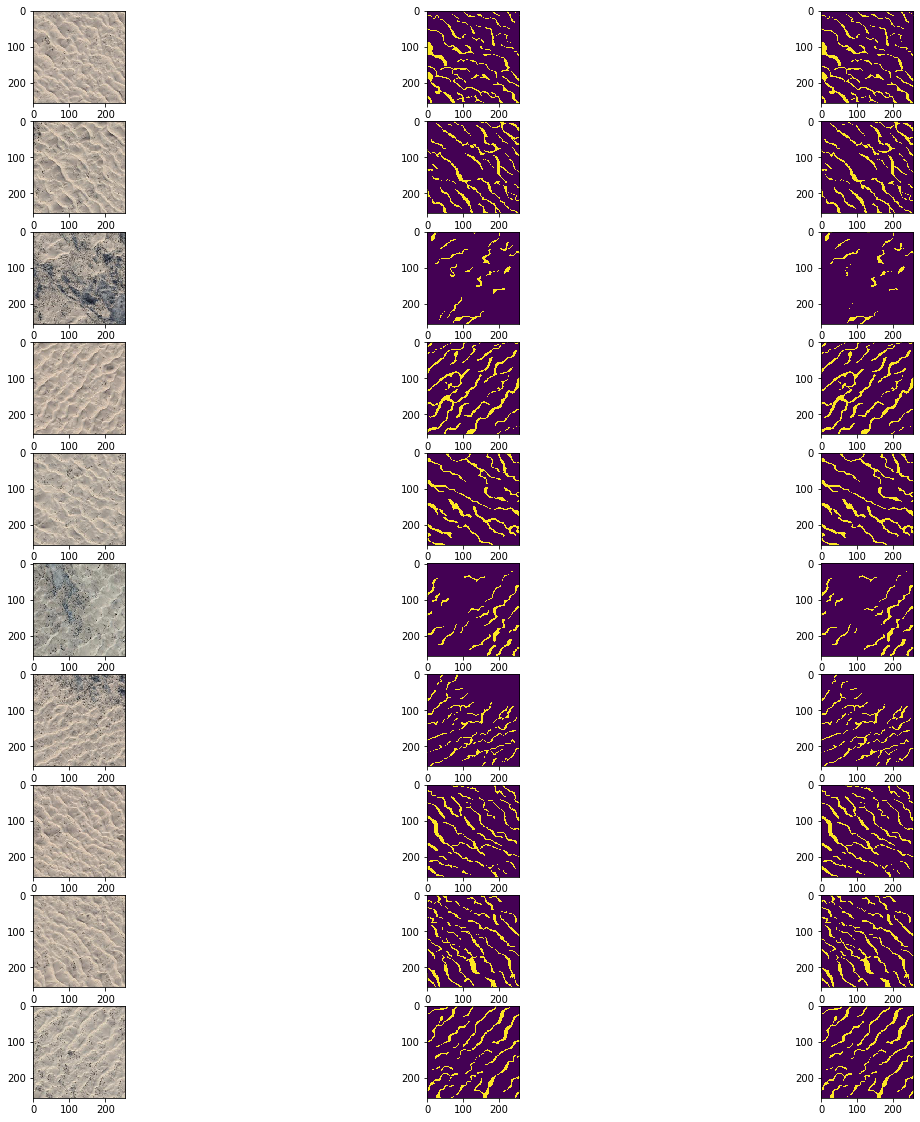

In [32]:
# 在训练数据上看效果：
num = 10 # 一次看5张效果！

for image, label_real in train_dataset.take(1):
    label_pred = new_model.predict(image)
    label_pred = tf.argmax( label_pred, axis = -1 )  # 每个维度上，取一个最大值！
    
    plt.figure( figsize=(20,20) )
    # 每行3张图，从左到右：原图、真实标签图、预测标签图
    for i in range(num):
        plt.subplot(num, 3, i*3 + 1)
        plt.imshow( (image[i].numpy() + 1)/2 )
        plt.subplot(num, 3, i*3 + 2)
        plt.imshow( label_real[i].numpy().reshape(256,256) )
        plt.subplot(num, 3, i*3 + 3)
        plt.imshow( label_pred[i].numpy().reshape(256,256) )

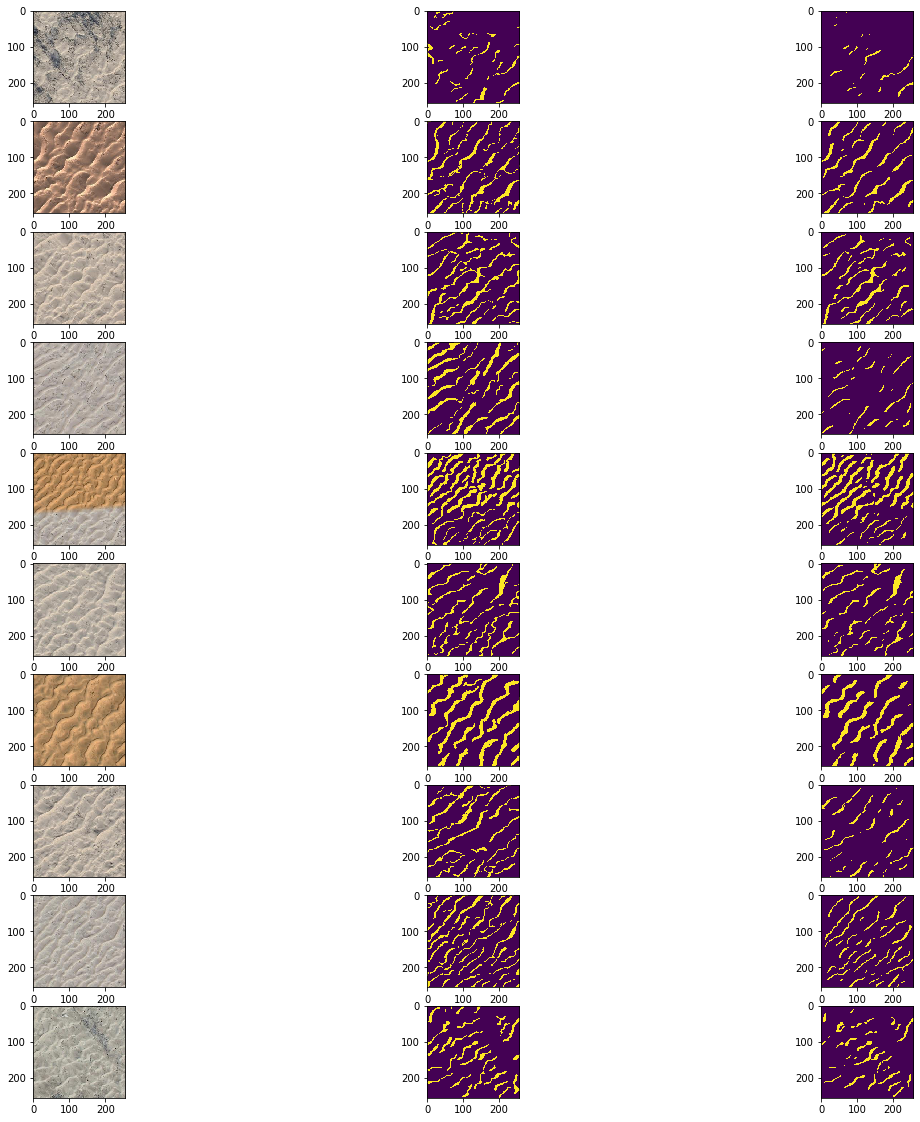

In [33]:
# 在训练数据上看效果：
num = 10 # 一次看10张效果！

for image, label_real in val_dataset.take(1):
    label_pred = new_model.predict(image)
    label_pred = tf.argmax( label_pred, axis = -1 )  # 每个维度上，取一个最大值！
    
    plt.figure( figsize=(20,20) )
    # 每行3张图，从左到右：原图、真实标签图、预测标签图
    for i in range(num):
        plt.subplot(num, 3, i*3 + 1)
        plt.imshow( (image[i].numpy() + 1)/2 )
        plt.subplot(num, 3, i*3 + 2)
        plt.imshow( label_real[i].numpy().reshape(256,256) )
        plt.subplot(num, 3, i*3 + 3)
        plt.imshow( label_pred[i].numpy().reshape(256,256) )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


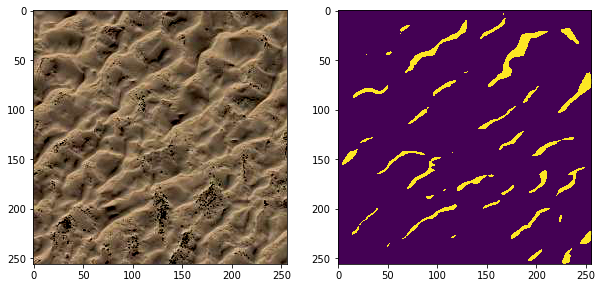

In [34]:
# 用当前模型测试一张图：
img_test = glob.glob( r'/home/gaoboyu/学习数据集/沙漠数据集3/subimg_212.png' )

img_test = read_image(img_test[0])
img_test = tf.cast(img_test, tf.float32) / 127.5 - 1  # 归到[-1,1]之间！—— 和输入数据一致！
img_test = tf.expand_dims( img_test, axis = 0 )

label_pred = new_model.predict(img_test)
label_pred = tf.argmax( label_pred, axis = -1 )  # 每个维度上，取一个最大值！

img_test = tf.squeeze( img_test, axis = 0 )

plt.figure( figsize=(10,10) )
plt.subplot(1, 2, 1)
plt.imshow( img_test.numpy() )
plt.subplot(1, 2, 2)
plt.imshow( label_pred[0].numpy().reshape(256,256) )

In [65]:
img_test = tf.cast(img_test, tf.float32) / 127.5 - 1

In [66]:
img_test

<tf.Tensor: shape=(256, 256, 3), dtype=float32, numpy=
array([[[ 0.09019613, -0.16862744, -0.30196077],
        [-0.02745098, -0.23921567, -0.3098039 ],
        [-0.00392157, -0.21568626, -0.2862745 ],
        ...,
        [ 0.2941177 ,  0.04313731, -0.1372549 ],
        [ 0.26274514,  0.0196079 , -0.14509803],
        [ 0.21568632, -0.02745098, -0.19215685]],

       [[ 0.09803927, -0.1607843 , -0.29411763],
        [-0.19999999, -0.42745095, -0.49019605],
        [-0.12156862, -0.34117645, -0.42745095],
        ...,
        [ 0.27843142,  0.03529418, -0.12941176],
        [ 0.23921573, -0.00392157, -0.16862744],
        [ 0.17647064, -0.04313725, -0.21568626]],

       [[ 0.09019613, -0.16862744, -0.30196077],
        [-0.16862744, -0.38823527, -0.47450978],
        [-0.05882353, -0.27843136, -0.372549  ],
        ...,
        [ 0.22352946, -0.01960784, -0.18431371],
        [ 0.1686275 , -0.05098039, -0.21568626],
        [ 0.12156868, -0.09803921, -0.26274508]],

       ...,

     

In [ ]:
# 备用模型保存函数 + 导入：保存当前模型 —— 临时保存在当前目录下。
model.save( '/home/gaoboyu/学习保存的模型/沙漠5/model5_150_调过拟合_半网.h5' )
# new_model = tf.keras.models.load_model( 'model5_150_调过拟合_半网.h5' )

In [60]:
new_model = tf.keras.models.load_model( '/home/gaoboyu/学习保存的模型/沙漠7_用6模型' )

In [ ]:
# 在训练数据上看效果：
num = 10 # 一次看10张效果！

for image, label_real in val_dataset.take(1):
    label_pred = model.predict(image)
    label_pred = tf.argmax( label_pred, axis = -1 )  # 每个维度上，取一个最大值！
    
    plt.figure( figsize=(20,20) )
    # 每行3张图，从左到右：原图、真实标签图、预测标签图
    for i in range(num):
        plt.subplot(num, 3, i*3 + 1)
        plt.imshow( (image[i].numpy() + 1)/2 )
        plt.subplot(num, 3, i*3 + 2)
        plt.imshow( label_real[i].numpy().reshape(256,256) )
        plt.subplot(num, 3, i*3 + 3)
        plt.imshow( label_pred[i].numpy().reshape(256,256) )